# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

### THIS IS  A TEST OF THE MANUAL PROCESS

In [186]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [137]:
feat_info_copy = feat_info.copy()

#Parsing "missing_or_unknown" and adding characters to list
feat_info_copy['missing_or_unknown'] = (
    feat_info_copy['missing_or_unknown']
    .str.strip('[]') #strip bracket
    .str.split(',') #split by comma
    .apply(lambda x: [int(i) if i.lstrip('-').isdigit() else i.strip().strip("'") for i in x]) #convert to correct type
)


In [138]:
# Creating copy of azdias for data manipulation
azdias_copy = azdias.copy()

In [139]:
# Updating azdias_copy to convert attributes in the info df to NaN
for index, row in feat_info_copy.iterrows():
    attribute = row['attribute']
    missing_or_unknown = row['missing_or_unknown']
    if attribute in azdias_copy.columns:
        azdias_copy[attribute] = azdias_copy[attribute].apply(lambda x: np.nan if x in missing_or_unknown else x)


In [140]:
azdias_copy.shape

(891221, 85)

In [141]:
# Remove the outlier columns from the dataset.
azdias_copy.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1, inplace=True)
azdias_copy.shape

(891221, 79)

In [142]:
# Create categorical and mixed filters
categorical_columns_filter = feat_info_copy[feat_info_copy['type'] == 'categorical']['attribute']
mixed_columns_filter = feat_info_copy[feat_info_copy['type'] == 'mixed']['attribute']

In [143]:
#Re-encoding OST_WEST_KZ to binary features
azdias_copy['OST_WEST_KZ'] = azdias_copy['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

# Convert to 
azdias_copy.shape

(891221, 79)

In [144]:
#Dropping categorical columns with more than 2 unique features
for col in categorical_columns_filter:
    if col in azdias_copy.columns and azdias_copy[col].nunique() > 2:
         #Drop the columns
        azdias_copy.drop(columns=[col], inplace=True)
azdias_copy.shape

(891221, 66)

In [145]:
# Mapping for decades
decade_dict = {
    1: 40, 2: 40, # 40s
    3: 50, 4: 50, # 50s
    5: 60, 6: 60, 7: 60, # 60s
    8: 70, 9: 70, # 70s
    10: 80, 11: 80, 12: 80, 13: 80, # 80s
    14: 90, 15: 90 # 90s
}

# Mapping for movement: Mainstream = 0, Avantgarde = 1
movement_dict = {
    1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, # Mainstream
    2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1  # Avantgarde
}

In [146]:
# Creating new features in azdias_copy
azdias_copy['DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
azdias_copy['MOVEMENT'] = azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
azdias_copy.shape

(891221, 68)

In [147]:
# Extract 'TENS' column
azdias_copy['CAMEO_INTL_2015_TENS'] = azdias_copy['CAMEO_INTL_2015'].str[0]

# Extract 'ONES' column
azdias_copy['CAMEO_INTL_2015_ONES'] = azdias_copy['CAMEO_INTL_2015'].str[1]
azdias_copy.shape

(891221, 70)

In [148]:
# Dropping old columns used for engineering 
azdias_copy.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
azdias_copy.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
azdias_copy.shape

(891221, 68)

In [149]:
# get the names of columns which are mixed type and still present in azdias_copy
valid_mixed_columns_filter = [col for col in mixed_columns_filter if col in azdias_copy.columns]

# Dropping mixed
azdias_copy.drop(valid_mixed_columns_filter, axis=1, errors='ignore', inplace=True)
azdias_copy_test1 = azdias_copy
azdias_copy_test1.shape#REMOVE


(891221, 64)

### END TEST OF THE MANUAL PROCESS

In [187]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [117]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape


(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.shape

(85, 4)

In [6]:
feat_info.head(20)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [188]:
# Copy feat_info for later data manipulation
feat_info_copy = feat_info.copy()

In [156]:
# Finding all missing value
feat_info_copy["missing_or_unknown"].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[XX]         1
[-1,XX]      1
[-1,X]       1
Name: missing_or_unknown, dtype: int64

In [189]:
#Parsing "missing_or_unknown" and adding characters to list
feat_info_copy['missing_or_unknown'] = (
    feat_info_copy['missing_or_unknown']
    .str.strip('[]') #strip bracket
    .str.split(',') #split by comma
    .apply(lambda x: [int(i) if i.lstrip('-').isdigit() else i.strip().strip("'") for i in x]) #convert to correct type
)


In [121]:
# Checking that "missing_or_unknown" now contains lists
print(type(feat_info_copy.loc[0, 'missing_or_unknown']))


<class 'list'>


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [228]:
# Identify missing or unknown data values and save to dataframe
azdias_missing_data_count = azdias.isna().sum()
feat_info_missing_data_count = feat_info.isna().sum()

In [229]:
# Total natural NaN
azdias.isna().sum().sum()

4896838

In [230]:
azdias_missing_data_sort = azdias_missing_data_count.sort_values()
azdias_missing_data_sort.head(20)

AGER_TYP                 0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
PRAEGENDE_JUGENDJAHRE    0
SEMIO_KULT               0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SHOPPER_TYP              0
VERS_TYP                 0
SEMIO_RAT                0
NATIONALITAET_KZ         0
ZABEOTYP                 0
dtype: int64

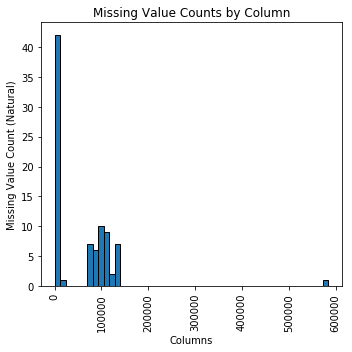

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Create histogram plot

plt.figure(figsize =(5,5))
azdias_missing_data_sort.plot(kind='hist', edgecolor='black', bins=50)
plt.xticks(rotation='vertical')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count (Natural)')
plt.title('Missing Value Counts by Column')
plt.tight_layout()
plt.show();


In [231]:
# Removing 0 counts for easier viewing
azdias_missing_data_sort0 = azdias_missing_data_sort[azdias_missing_data_sort > 0]
azdias_missing_data_sort0.head(20)

ONLINE_AFFINITAET       4854
CJT_GESAMTTYP           4854
LP_STATUS_GROB          4854
LP_LEBENSPHASE_FEIN     4854
GFK_URLAUBERTYP         4854
LP_FAMILIE_GROB         4854
LP_FAMILIE_FEIN         4854
LP_STATUS_FEIN          4854
RETOURTYP_BK_S          4854
LP_LEBENSPHASE_GROB     4854
HH_EINKOMMEN_SCORE     18348
TITEL_KZ               73499
ANZ_PERSONEN           73499
ANZ_TITEL              73499
WOHNDAUER_2008         73499
SOHO_KZ                73499
ALTER_HH               73499
KONSUMNAEHE            73969
WOHNLAGE               93148
OST_WEST_KZ            93148
dtype: int64

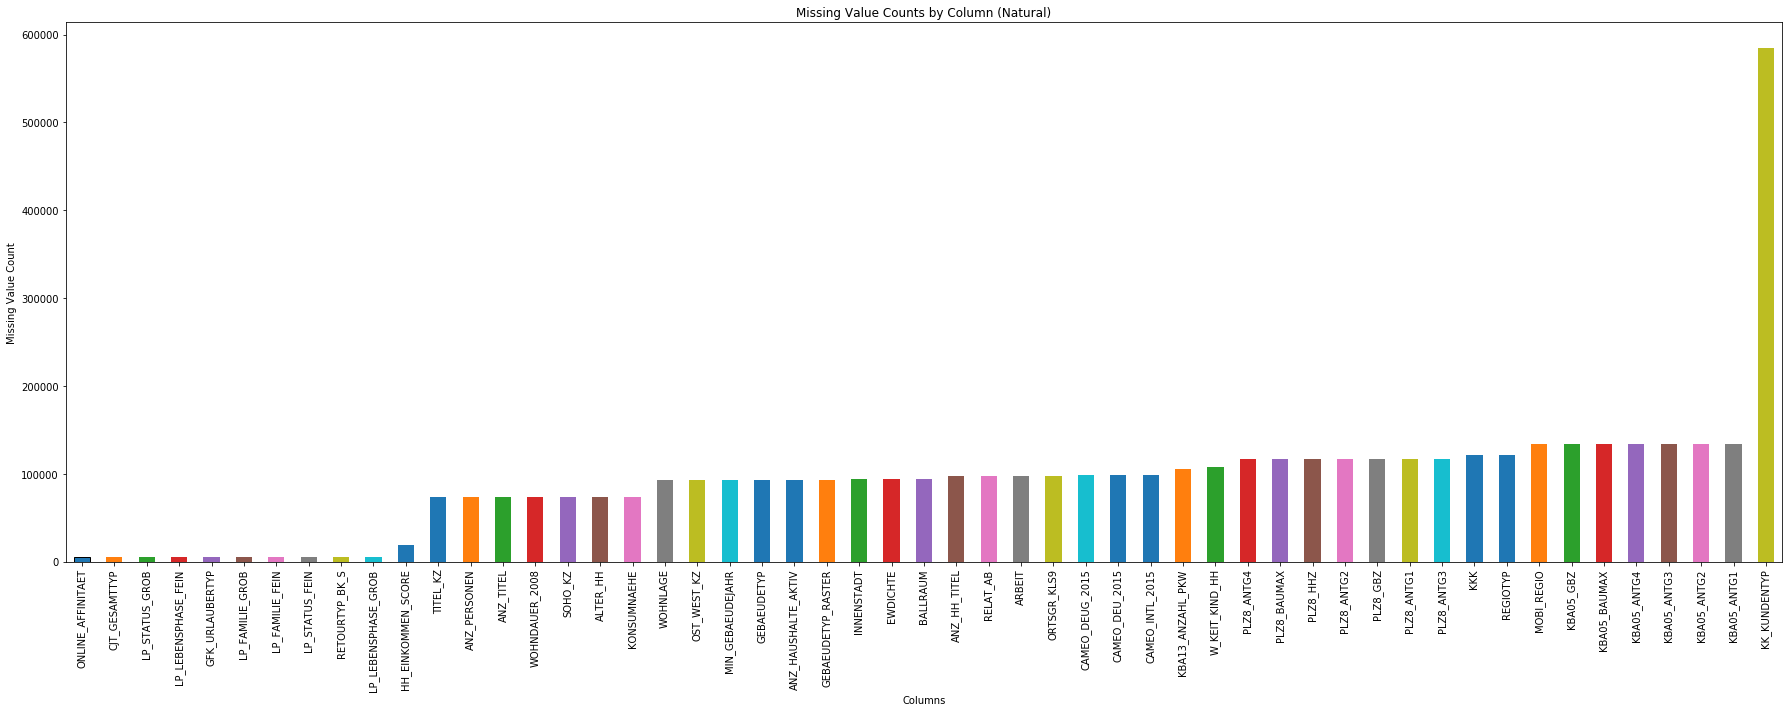

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize =(25,10))
azdias_missing_data_sort0.plot(kind='bar', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.title('Missing Value Counts by Column (Natural)')
plt.tight_layout()
plt.show();

# Data Cleansing

In [190]:
# Creating copy of azdias for data manipulation
azdias_copy = azdias.copy()


In [191]:
# Updating azdias_copy to convert attributes in the info df to NaN
for index, row in feat_info_copy.iterrows():
    attribute = row['attribute']
    missing_or_unknown = row['missing_or_unknown']
    if attribute in azdias_copy.columns:
        azdias_copy[attribute] = azdias_copy[attribute].apply(lambda x: np.nan if x in missing_or_unknown else x)


In [164]:
# Total original NaN
azdias.isna().sum().sum()

4896838

In [21]:
# Total processed NaN
azdias_copy.isna().sum().sum()

8373929

In [192]:
azdias_missing_copy = azdias_copy.isna().sum()

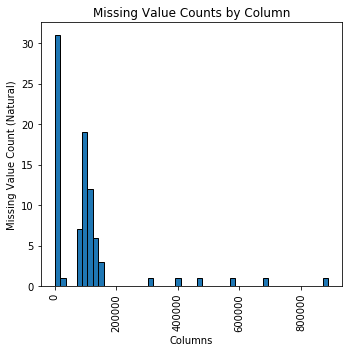

In [23]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Create histogram plot

plt.figure(figsize =(5,5))
azdias_missing_copy.plot(kind='hist', edgecolor='black', bins=50)
plt.xticks(rotation='vertical')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count (Natural)')
plt.title('Missing Value Counts by Column')
plt.tight_layout()
plt.show();


In [193]:
# Removing 0 counts for easier viewing
azdias_missing_copy0 = azdias_missing_copy[azdias_missing_copy > 0]

#Sorting by missing value count
azdias_missing_copy0 = azdias_missing_copy0.sort_values()

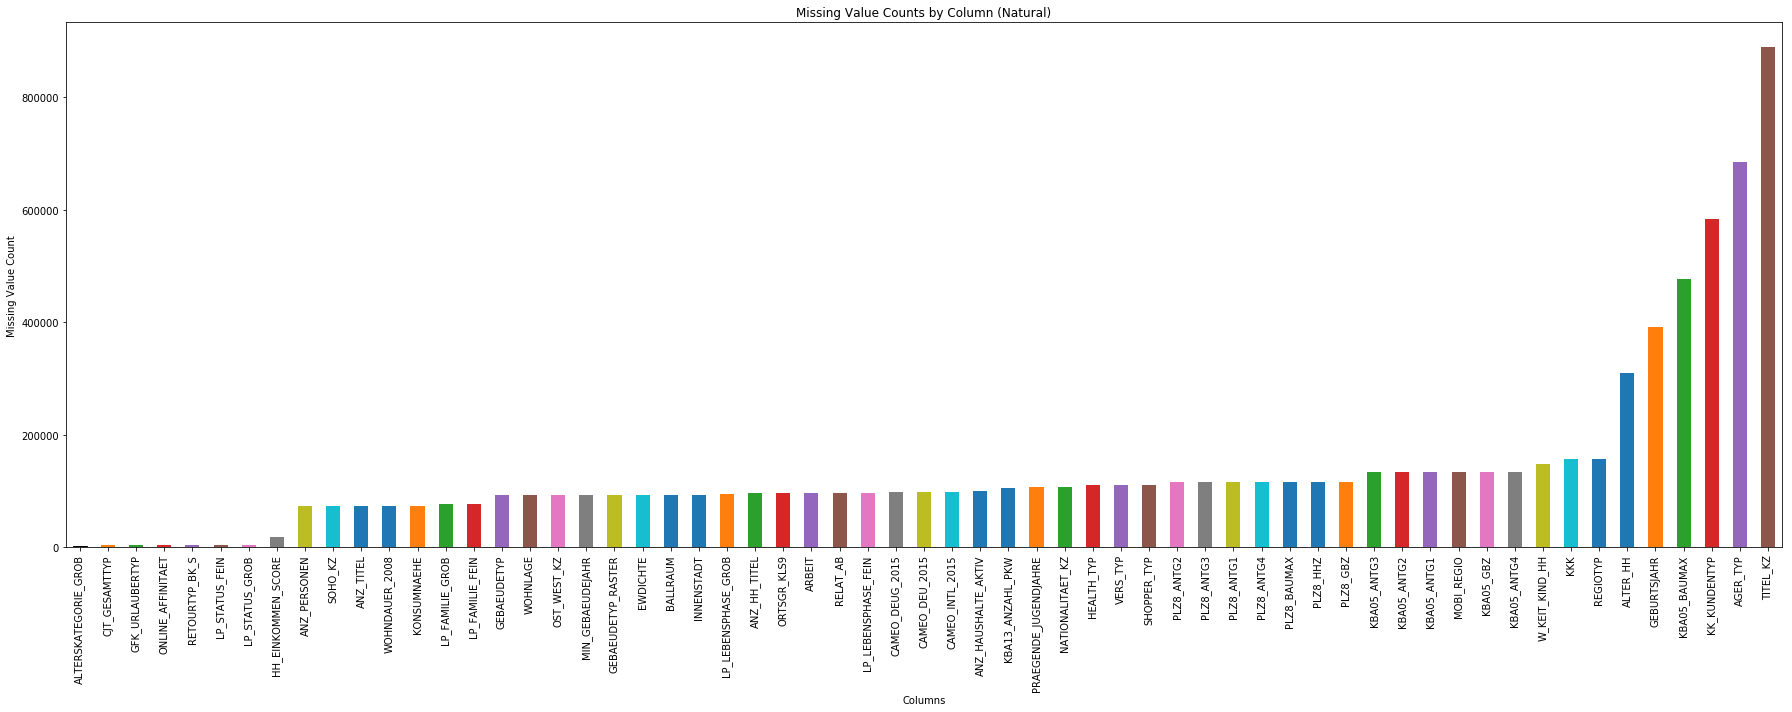

In [25]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize =(25,10))
azdias_missing_copy0.plot(kind='bar', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.title('Missing Value Counts by Column (Natural)')
plt.tight_layout()
plt.show();

In [167]:
# Investigate patterns in the amount of missing data in each column with raw numbers.
print(azdias_missing_copy0.tail(10))

KBA05_ANTG4       133324
W_KEIT_KIND_HH    147988
KKK               158064
REGIOTYP          158064
ALTER_HH          310267
GEBURTSJAHR       392318
KBA05_BAUMAX      476524
KK_KUNDENTYP      584612
AGER_TYP          685843
TITEL_KZ          889061
dtype: int64


In [194]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_copy.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1, inplace=True)

print(azdias_copy.shape)

(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

Before utilizing the feat_info file to update missing or unknown we had 4,896,838 cells with missing data. There was only one outlier, KK_KUNDENTYP. After the update, we found 8,373,929 cells with missing data and six outlier columns that contained the majority of our missing data. We confirmed that the majority of the data was contained in columns that had fewer than 16k missing cells via a histogram and then with a bar chart. We then removed the six outliers from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [214]:
# How much data is missing in each row of the dataset?
average_nan_per_row = azdias_copy.isna().sum(axis=1).mean()
average_nan_per_row

4.6616832413060285

In [217]:
# How much data is missing in each row of the dataset?
sum_nan_per_row = azdias_copy.isna().sum(axis=1)
sum_nan_per_row

0         38
1          0
2          0
3          3
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        38
12         6
13         8
14        38
15         7
16         2
17        38
18         3
19         0
20         9
21         0
22         0
23         7
24        38
25         1
26        17
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    11
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     2
891218     1
891219     0
891220     0
Length: 891221, dtype: int64

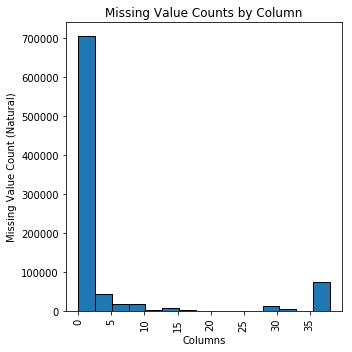

In [221]:
# Perform an assessment of how much missing data there is in each row of the
# dataset.
# Create histogram plot

plt.figure(figsize =(5,5))
sum_nan_per_row.plot(kind='hist', edgecolor='black', bins=15)
plt.xticks(rotation='vertical')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count (Natural)')
plt.title('Missing Value Counts by Column')
plt.tight_layout()
plt.show();


In [222]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_row_missing_low = azdias_copy[sum_nan_per_row <= 10]
azdias_row_missing_high = azdias_copy[sum_nan_per_row > 10]


In [223]:
azdias_row_missing_low.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0,5,4


In [224]:
azdias_row_missing_high.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


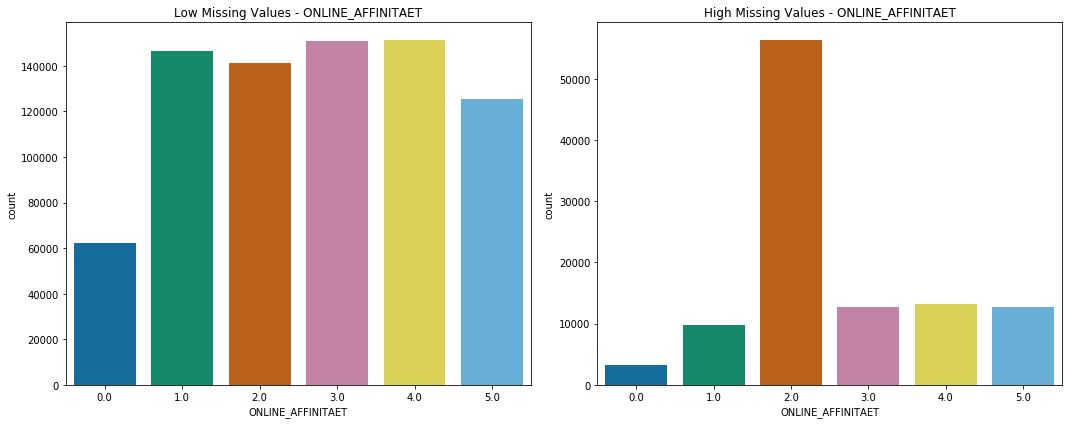

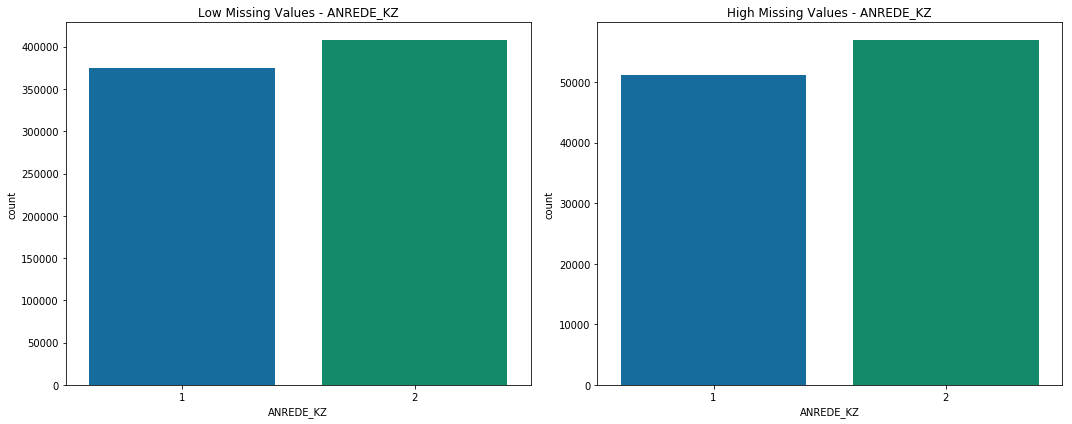

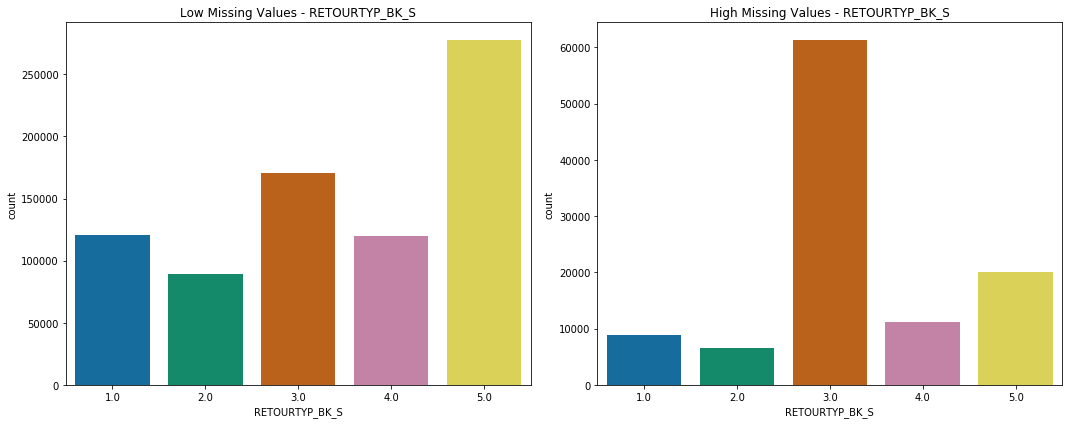

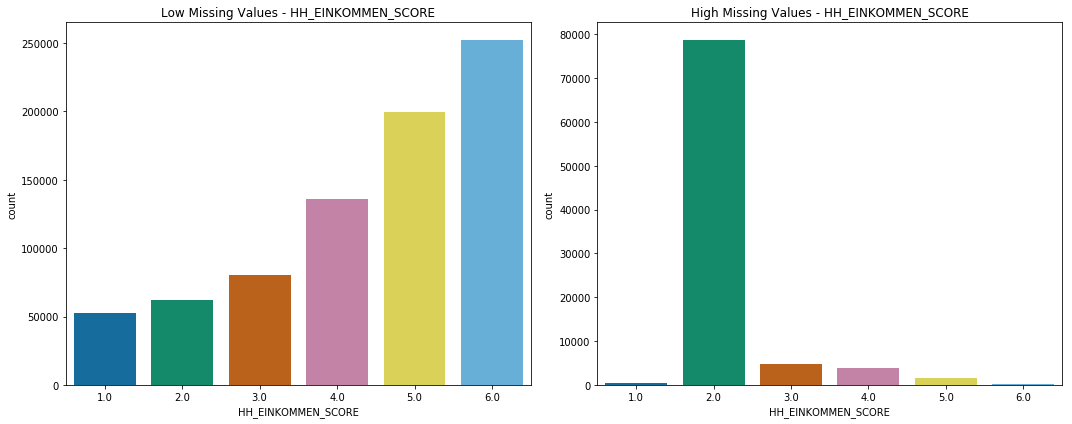

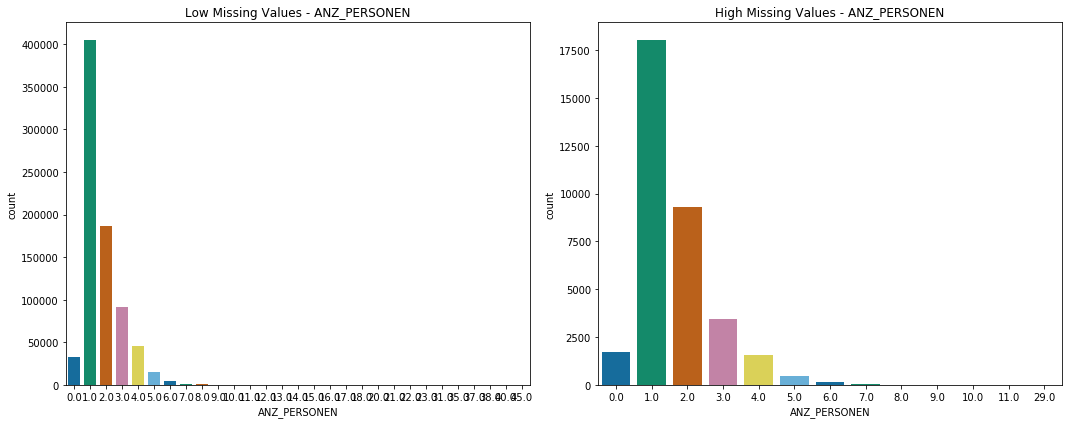

In [242]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_to_compare = ['ONLINE_AFFINITAET', 'ANREDE_KZ', 'RETOURTYP_BK_S', 'HH_EINKOMMEN_SCORE', 'ANZ_PERSONEN']

for column in columns_to_compare:
    fig, ax =plt.subplots(1,2, figsize=(15, 6))
    sns.color_palette("hls", 8)

    sns.countplot(data=azdias_row_missing_low, x=column, ax=ax[0], palette = sns.color_palette("colorblind"))
    ax[0].set_title(f'Low Missing Values - {column}')

    sns.countplot(data=azdias_row_missing_high, x=column, ax=ax[1], palette = sns.color_palette("colorblind"))
    ax[1].set_title(f'High Missing Values - {column}')

    plt.tight_layout()
    plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

After investigating missing data by bar chart and listing the columns with the most missing data, I came to the conclustion that any columns with more than 15k NaNs were outliers. Columns 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', and 'ALTER_HH' all had higher than normal missing data so we dropped them from the dataframe. 

To identify the threshold for rows with high or low missing data, I plotted the distribution. I found that rows with more than 10 missing datatypes to outliers and therefore, high.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info.groupby('type').count()['attribute']


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

In [34]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [35]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
azdias_copy.nunique().sort_values(ascending=False)



KBA13_ANZAHL_PKW         1261
ANZ_HAUSHALTE_AKTIV       291
CAMEO_DEU_2015             44
LP_LEBENSPHASE_FEIN        40
MIN_GEBAEUDEJAHR           32
ANZ_PERSONEN               30
CAMEO_INTL_2015            21
ANZ_HH_TITEL               21
PRAEGENDE_JUGENDJAHRE      15
LP_LEBENSPHASE_GROB        12
GFK_URLAUBERTYP            12
LP_FAMILIE_FEIN            11
LP_STATUS_FEIN             10
ORTSGR_KLS9                 9
CAMEO_DEUG_2015             9
WOHNDAUER_2008              9
WOHNLAGE                    8
INNENSTADT                  8
SEMIO_SOZ                   7
SEMIO_KAEM                  7
GEBAEUDETYP                 7
SEMIO_RAT                   7
SEMIO_FAM                   7
SEMIO_TRADV                 7
SEMIO_KULT                  7
SEMIO_ERL                   7
SEMIO_PFLICHT               7
SEMIO_LUST                  7
SEMIO_KRIT                  7
SEMIO_VERT                  7
                         ... 
FINANZ_ANLEGER              5
FINANZ_VORSORGER            5
FINANZ_SPA

In [195]:
#Dropping rows that have attributes no dropped from azdias_copy to prevent Key Error
feat_info_copy = feat_info[~feat_info['attribute'].isin(['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX'])]



In [196]:
# get the names of columns which are categorical
categorical_columns_filter = feat_info_copy[feat_info_copy['type'] == 'categorical']['attribute']

# subset azdias_copy by the categorical columns
categorical_azdias = azdias_copy[categorical_columns_filter]

# count unique values in each categorical column
unique_counts = categorical_azdias.nunique().sort_values(ascending=False)

print(unique_counts)

CAMEO_DEU_2015      44
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_STATUS_FEIN      10
CAMEO_DEUG_2015      9
GEBAEUDETYP          7
CJT_GESAMTTYP        6
ZABEOTYP             6
FINANZTYP            6
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
SHOPPER_TYP          4
NATIONALITAET_KZ     3
GREEN_AVANTGARDE     2
SOHO_KZ              2
VERS_TYP             2
OST_WEST_KZ          2
ANREDE_KZ            2
dtype: int64


In [197]:
#print binary columns to see what data they hold
binary_columns = ['GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ', 'ANREDE_KZ']
for feature in binary_columns:
    print(feature, azdias_copy[feature].unique())


GREEN_AVANTGARDE [0 1]
SOHO_KZ [ nan   1.   0.]
VERS_TYP [ nan   2.   1.]
OST_WEST_KZ [nan 'W' 'O']
ANREDE_KZ [1 2]


In [198]:
#Re-encoding OST_WEST_KZ to binary features
azdias_copy['OST_WEST_KZ'] = azdias_copy['OST_WEST_KZ'].replace({'W': 0, 'O': 1})


In [199]:
#Checking re-encoding
binary_columns = ['GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ', 'ANREDE_KZ']
for feature in binary_columns:
    print(feature, azdias_copy[feature].unique())

GREEN_AVANTGARDE [0 1]
SOHO_KZ [ nan   1.   0.]
VERS_TYP [ nan   2.   1.]
OST_WEST_KZ [ nan   0.   1.]
ANREDE_KZ [1 2]


In [200]:
#Checking shape before dropping columns to confirm shape after
azdias_copy.shape

(891221, 79)

In [201]:
#Dropping categorical columns with more than 2 unique features
for col in categorical_columns_filter:
    if col in azdias_copy.columns and azdias_copy[col].nunique() > 2:
         #Drop the columns
        azdias_copy.drop(columns=[col], inplace=True)


In [202]:
azdias_copy.shape

(891221, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

There were 18 categorical features in the dataframe. Only 5 of them were binary. for simplicity's sake, I removed any features that contained more than 2 unique values. OST_WEST_KZ contained non numerical characters representing the binary values. I needed to recode them to numerical values for scikit learn to handle them correctly. "W" now equals 0 and "O" now equals 1. 

In [203]:
# get the names of columns which are mixed
mixed_columns_filter = feat_info_copy[feat_info_copy['type'] == 'mixed']['attribute']

# subset azdias_copy by the categorical columns
categorical_azdias = azdias_copy[mixed_columns_filter]

# count unique values in each categorical column
unique_counts = categorical_azdias.nunique()

print(unique_counts)

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [45]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
for feature in ['PRAEGENDE_JUGENDJAHRE']:
    print(feature, azdias_copy[feature].unique())

PRAEGENDE_JUGENDJAHRE [ nan  14.  15.   8.   3.  10.  11.   5.   9.   6.   4.   2.   1.  12.  13.
   7.]


In [204]:
# Mapping for decades
decade_dict = {
    1: 40, 2: 40, # 40s
    3: 50, 4: 50, # 50s
    5: 60, 6: 60, 7: 60, # 60s
    8: 70, 9: 70, # 70s
    10: 80, 11: 80, 12: 80, 13: 80, # 80s
    14: 90, 15: 90 # 90s
}

# Mapping for movement: Mainstream = 0, Avantgarde = 1
movement_dict = {
    1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, # Mainstream
    2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1  # Avantgarde
}


In [205]:
azdias_copy.shape

(891221, 66)

In [206]:
# Creating new features in azdias_copy
azdias_copy['DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
azdias_copy['MOVEMENT'] = azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
azdias_copy.shape # Checking that new fatures were added

(891221, 68)

In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
for feature in ['CAMEO_INTL_2015']:
    print(feature, azdias_copy[feature].unique())



CAMEO_INTL_2015 [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']


In [207]:
# Extract 'TENS' column
azdias_copy['CAMEO_INTL_2015_TENS'] = azdias_copy['CAMEO_INTL_2015'].str[0]

# Extract 'ONES' column
azdias_copy['CAMEO_INTL_2015_ONES'] = azdias_copy['CAMEO_INTL_2015'].str[1]
azdias_copy.shape

(891221, 70)

#### Discussion 1.2.2: Engineer Mixed-Type Features

**PRAEGENDE_JUGENDJAHRE:** Contained multiple features in each cell; the decade, name of the movement, and if the movement was considered mainstream or avantgarde. It was thankfully ordered by decade and then alternated between movement type, making it easier to parse via a dictionary. (Mainstream being odd indexes and Avantgarde being even)

**CAMEO_INTL_2015** Contained 2 features in each cell; wealth category and life stage. Since each wealth category uses the same tens digit and the ones increase by 1, we can use these as ordinal values in our scikit learn. ( we don't need the non-numerical parts) These also needed to be separated and added to two columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [51]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [208]:
# Dropping old columns used for engineering 
azdias_copy.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
azdias_copy.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
azdias_copy.shape

(891221, 68)

In [209]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# get the names of columns which are mixed type and still present in azdias_copy
valid_mixed_columns_filter = [col for col in mixed_columns_filter if col in azdias_copy.columns]

# Dropping mixed still present
azdias_copy.drop(valid_mixed_columns_filter, axis=1, errors='ignore', inplace=True)
azdias_copy_test1 = azdias_copy
azdias_copy_test1.shape#REMOVE

(891221, 64)

In [ ]:
# Create copy of manually cleaned data for later comparison
azdias_manual_clean = azdias_copy

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [260]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Load in the general demographics data.
    azdias = df
    


    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    # Creating copy of feature_info for data manipulation
    feat_info_copy = feat_info.copy()
    
    #Parsing "missing_or_unknown" and adding characters to list
    feat_info_copy['missing_or_unknown'] = (
        feat_info_copy['missing_or_unknown']
        .str.strip('[]') #strip bracket
        .str.split(',') #split by comma
        .apply(lambda x: [int(i) if i.lstrip('-').isdigit() else i.strip().strip("'") for i in x]) #convert to correct type
    )

    # Creating copy of azdias for data manipulation
    azdias_copy = azdias.copy()

    # convert missing value codes into NaNs, ...
    # Updating azdias_copy to convert attributes in the info df to NaN
    for index, row in feat_info_copy.iterrows():
        attribute = row['attribute']
        missing_or_unknown = row['missing_or_unknown']
        if attribute in azdias_copy.columns:
            azdias_copy[attribute] = azdias_copy[attribute].apply(lambda x: np.nan if x in missing_or_unknown else x)
   
    
    # remove selected columns and rows, ...
    # Remove the outlier columns from the dataset.
    azdias_copy.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1, inplace=True)

    #Dropping rows that have attributes dropped from azdias_copy to prevent Key Error
    feat_info_copy = feat_info[~feat_info['attribute'].isin(['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX'])]
    
    # select, re-encode, and engineer column values.
    # get the names of columns which are categorical
    categorical_columns_filter = feat_info_copy[feat_info_copy['type'] == 'categorical']['attribute']
    
    # get the names of columns which are mixed
    mixed_columns_filter = feat_info_copy[feat_info_copy['type'] == 'mixed']['attribute']
    
    #Re-encoding OST_WEST_KZ to binary features    
    azdias_copy['OST_WEST_KZ'] = azdias_copy['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

    
    #Dropping categorical columns with more than 2 unique features
    for col in categorical_columns_filter:
        if col in azdias_copy.columns and azdias_copy[col].nunique() > 2:
             #Drop the columns
            azdias_copy.drop(columns=[col], inplace=True)
            
    # Mapping for decades
    decade_dict = {
        1: 40, 2: 40, # 40s
        3: 50, 4: 50, # 50s
        5: 60, 6: 60, 7: 60, # 60s
        8: 70, 9: 70, # 70s
        10: 80, 11: 80, 12: 80, 13: 80, # 80s
        14: 90, 15: 90 # 90s
    }

    # Mapping for movement: Mainstream = 0, Avantgarde = 1
    movement_dict = {
        1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, # Mainstream
        2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1  # Avantgarde
    }

    # Creating new features in azdias_copy
    azdias_copy['DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    azdias_copy['MOVEMENT'] = azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    # Extract 'TENS' column
    azdias_copy['CAMEO_INTL_2015_TENS'] = azdias_copy['CAMEO_INTL_2015'].str[0]

    # Extract 'ONES' column
    azdias_copy['CAMEO_INTL_2015_ONES'] = azdias_copy['CAMEO_INTL_2015'].str[1]
   
    # Dropping old columns used for engineering 
    azdias_copy.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    azdias_copy.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # get the names of columns which are mixed type and still present in azdias_copy
    valid_mixed_columns_filter = [col for col in mixed_columns_filter if col in azdias_copy.columns]

    # Dropping mixed still present
    azdias_copy.drop(valid_mixed_columns_filter, axis=1, errors='ignore', inplace=True)
    
    
    # Return the cleaned dataframe.
    df = azdias_copy
    
    #assert azdias_copy_test1.shape[0] == azdias_copy.shape[0], "clean_data function is not working properly, rows mismatch"
    #assert azdias_copy_test1.shape[1] == azdias_copy.shape[1], "clean_data function is not working properly, columns mismatch"

    print("If this is all you see, you passed the tests")
    return df

In [211]:
azdias_clean = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [212]:
azdias_clean = clean_data(azdias_clean)

If this is all you see, you passed the tests


In [213]:
azdias_clean.shape

(891221, 64)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [58]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_clean.isna().sum().sum()

4386778

In [244]:
# Imputing missing values
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='mean')
azdias_imp = pd.DataFrame(imputer.fit_transform(azdias_clean), columns=azdias_clean.columns)
azdias_imp.isna().sum().sum() # Outputs count of missing data for qc

0

In [245]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imp), columns=azdias_imp.columns)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,-0.750972,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.000000,...,1.637641e-16,-4.890471e-16,-4.284963e-16,-4.709754e-16,2.042688e-15,-3.458487e-16,3.116720e-15,-1.420953e-16,3.216984e-16,6.346104e-16
1,-1.742724,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,1.146266,...,4.437471e-01,1.527612e+00,5.971822e-01,-1.767775e-01,-1.349507e-01,7.234631e-01,1.218829e+00,-5.727990e-01,1.258937e+00,-1.338297e+00
2,0.240781,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,1.146266,...,-1.031309e+00,4.263757e-01,5.971822e-01,-1.767775e-01,-1.349507e-01,-8.341011e-01,1.218829e+00,1.986963e+00,-9.142640e-01,8.052265e-01
3,1.232533,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.269102,...,-1.031309e+00,-6.748605e-01,5.971822e-01,-1.237320e+00,-1.054896e+00,-5.531897e-02,-2.433020e-01,-5.727990e-01,-1.638664e+00,-6.237891e-01
4,0.240781,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,1.146266,...,4.437471e-01,-6.748605e-01,-3.677058e-01,8.837647e-01,3.250218e-01,1.502245e+00,-2.433020e-01,-5.727990e-01,5.345367e-01,9.071870e-02


### Discussion 2.1: Apply Feature Scaling

To apply feature scaling, I needed to deal with missing data first. Our data contained a lot of missing data so I imputed the data by replacing the missing data with the mean for the column. If there were fewer rows with missing data, I might have just chosen to delete them since it's easier than imputing. After imputing, I was able to correctly scale the data so that the values were standardized.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [246]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit(azdias_scaled)
azdias_pca


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

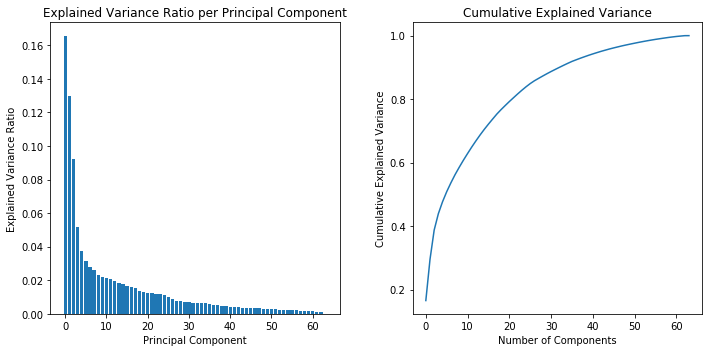

In [247]:
# Investigate the variance accounted for by each principal component.
# Generate the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Generate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio for each component
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component')

plt.subplot(1, 2, 2)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')

plt.tight_layout()
plt.show()


In [267]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 40 )
azdias_pca = pca.fit_transform(azdias_scaled)
sum(pca.explained_variance_ratio_)


0.93800057960666416

### Discussion 2.2: Perform Dimensionality Reduction
Once I scaled the data, we performed PCA and charted it to get an idea of which components contained the most relevant data to keep. We started off with 64 components, but decided that there were diminishing returns after 40 components. I further confirmed our analysis by summing the explained_variance_ratio_. This showed that 40 components had an explained variance of about 94%. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [249]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def component_weights(df, component_index):
    pca = PCA(n_components=40)
    azdias_pca = pca.fit_transform(df)

    # Get the feature weights for the first principal component
    component = pca.components_[component_index]

    # Create a dataframe that contains the weights and corresponding features
    weights_df = pd.DataFrame({'weight': component, 'feature': azdias_scaled.columns})

    # Sort the dataframe by the absolute value of the weight (magnitude of contribution to principal component)
    weights_df = weights_df.sort_values(by='weight', ascending=False)
    
    return weights_df


In [253]:
weights_df1 = component_weights(azdias_scaled, 0)
# Print the sorted dataframe
print(weights_df1.head(2)) # Top weights
print(weights_df1.tail(2)) # Bottom Weights

      weight     feature
53  0.232836  PLZ8_ANTG3
54  0.225919  PLZ8_ANTG4
      weight     feature
51 -0.232227  PLZ8_ANTG1
47 -0.247179  MOBI_REGIO


In [254]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_df2 = component_weights(azdias_scaled, 1)
# Print the sorted dataframe
print(weights_df2.head(2)) # Top weights
print(weights_df2.tail(2)) # Bottom Weights


     weight               feature
0  0.270816  ALTERSKATEGORIE_GROB
4  0.250793      FINANZ_VORSORGER
      weight        feature
3  -0.257214  FINANZ_SPARER
60 -0.264289         DECADE


In [255]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_df3 = component_weights(azdias_scaled, 2)
# Print the sorted dataframe
print(weights_df3.head(2)) # Top weights
print(weights_df3.tail(2)) # Bottom Weights


      weight     feature
15  0.353706  SEMIO_VERT
11  0.290919   SEMIO_SOZ
      weight     feature
22 -0.360270  SEMIO_KAEM
1  -0.362735   ANREDE_KZ


### Discussion 2.3: Interpret Principal Components


### Cluster 1
**Positive Weights:**

| Weight | Feature | Definition |
|--------|---------|------------|
| 0.232836 | PLZ8_ANTG3 | Number of 6-10 family houses in the PLZ8 region |
| 0.225919 | PLZ8_ANTG4 | Number of 10+ family houses in the PLZ8 region |


**Negative Weights:**

| Weight | Feature | Definition |
|--------|---------|------------|
| -0.232227 | KBA05_ANTG1 | Number of 1-2 family houses in the microcell |
| -0.247179 | MOBI_REGIO | Movement patterns |


In cluster 1, the top positively weighted features are related to higher housing density while the negatively weighted features are the opposite and related to less housing density regions. The make sense in being having an opposing relationship. 

### Cluster 2
**Positive Weights:**

| Weight | Feature | Definition |
|--------|---------|------------|
| 0.270816 | ALTERSKATEGORIE_GROB | Estimated age based on given name analysis |
| 0.250793 | FINANZ_VORSORGER | Financial typology, for each dimension: (financial interests-Be Prepared) |


**Negative Weights:**

| Weight | Feature | Definition |
|--------|---------|------------|
| -0.257214 | FINANZ_SPARER | Financial typology, for each dimension: (money-saver) |
| -0.264289 | DECADE | Decade born |

In cluster 2, the top weighted features were estimated age and a financial interest in being prepared. The negative weights has a financial interest in saving money and decade born. It's harder to get a real read on this in comparison to the other two clusters. Being financially prepared doesn't seem too different to being a money savior and other than age, there isn't a clear relation between the positive and negative weights. 

### Cluster 3
**Positive Weights:**

| Weight | Feature | Definition |
|--------|---------|------------|
| 0.353706 | SEMIO_VERT | Personality typology, for each dimension: (dreamful) |
| 0.290919 | SEMIO_SOZ | Personality typology, for each dimension: (socially minded) |


**Negative Weights:**

| Weight | Feature | Definition |
|--------|---------|------------|
| -0.360270 | SEMIO_KAEM | Personality typology, for each dimension: (combative attitude) |
| -0.362735 | ANREDE_KZ | gender |


In cluster 3, the weights were based around personality typology. This is also the most conclusive cluster. The positively weighted traits were dreamful and socially minded. The negative weights contrast this with more negatively minded personality traits like combative attitude.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [256]:
from sklearn.cluster import KMeans
# Range of cluster numbers to try
cluster_range = [3, 6, 9, 12, 15, 18, 21, 24]

# List to save the models and their scores
kmeans_models = []
scores = []

# Over a number of different cluster counts...
for n_clusters in cluster_range:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_clusters)
    model = kmeans.fit(azdias_scaled)    
    
    # compute the average within-cluster distances.
    # Save the model and its score
    kmeans_models.append(model)
    # the .score() function returns negative value, so it's negated to get positive distance
    scores.append(-model.score(azdias_scaled))    
    
    

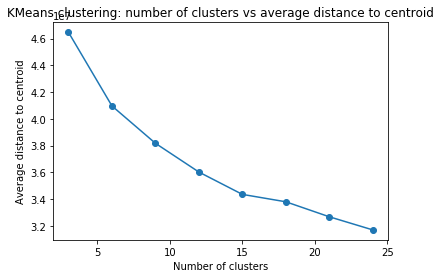

In [268]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_range, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to centroid')
plt.title('KMeans clustering: number of clusters vs average distance to centroid')
plt.show()


In [269]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(15)
model = kmeans.fit(azdias_pca) 
azdias_predicted = model.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

Utilizing the elbow method, I tried to ascertain the ideal number of clusters to evaluate. After 15 clusters, the average distance from the centeroid lessened about the same. For this reason I chose 15 clusters as the ideal amount to evaluate. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [270]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [271]:
customers.shape

(191652, 85)

In [277]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_clean = clean_data(customers)

customer_clean_imputed = imputer.transform(customer_clean)
customers_scaled = scaler.transform(customer_clean_imputed)
customers_pca = pca.transform(customers_scaled)  # apply the same pca transformation
customers_clusters = model.predict(customers_pca)  



If this is all you see, you passed the tests


In [266]:
print("azdias_clean shape:", azdias_clean.shape)
print("azdias_imp shape:", azdias_imp.shape)
print("azdias_scaled shape:", azdias_scaled.shape)
print("azdias_pca shape:", azdias_pca.shape)

print("customer_clean shape:", customer_clean.shape)
print("customer_clean_imputed shape:", customer_clean_imputed.shape)
print("customers_scaled shape:", customers_scaled.shape)
print("customers_pca shape:", customers_pca.shape)


azdias_clean shape: (891221, 64)
azdias_imp shape: (891221, 64)
azdias_scaled shape: (891221, 64)
azdias_pca shape: (891221, 40)
customer_clean shape: (191652, 64)
customer_clean_imputed shape: (191652, 64)
customers_scaled shape: (191652, 64)
customers_pca shape: (191652, 40)


In [276]:
print(pca.n_components_)
print(model.n_clusters)
print(model.cluster_centers_.shape)
print(customers_pca.shape)



40
15
(15, 40)
(191652, 40)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

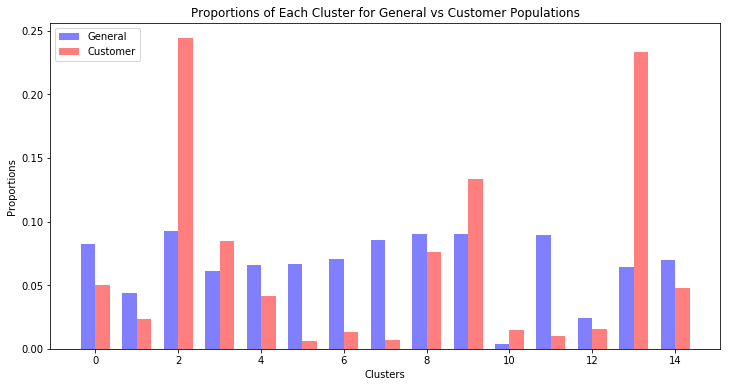

In [279]:
# Compute the proportion of data points in each cluster for the general population
azdias_proportions = pd.Series(azdias_predicted).value_counts(normalize=True).sort_index()

# Compute the proportion of data points in each cluster for the customer data
customer_proportions = pd.Series(customers_clusters).value_counts(normalize=True).sort_index()

# Create dataframe for proportions
df_proportions = pd.DataFrame({'General': azdias_proportions, 'Customer': customer_proportions})

# calculate appropriate widths for bars
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))

# create array for x-values, here df_proportions.index.values needs to be converted to array for the bar plot
x = np.arange(len(df_proportions.index.values))

# create bars for 'General' and 'Customer' in the same plot, adjust position by width/2
bar1 = ax.bar(x - width/2, df_proportions['General'], width, label='General', color='blue', alpha=0.5)
bar2 = ax.bar(x + width/2, df_proportions['Customer'], width, label='Customer', color='red', alpha=0.5)

# add labels, title, legend etc. 
ax.set_xlabel('Clusters')
ax.set_ylabel('Proportions')
ax.set_title('Proportions of Each Cluster for General vs Customer Populations')
ax.legend()

plt.show()


In [280]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# get cluster centroids from the kmeans model
centroids = model.cluster_centers_

centroids_pca_inv = pca.inverse_transform(centroids)
centroids_orig = scaler.inverse_transform(centroids_pca_inv)

df_centroids = pd.DataFrame(centroids_orig, columns=customer_clean.columns)

# Creating function to easily chart top clusters
def cluster_chart (cluster, bars):
    # Get top features for the given cluster
    top_features = df_centroids.iloc[cluster].sort_values(ascending=False)[:bars]

    # Generate the bar plot
    ax = top_features.plot(kind='bar')
    
    # Set title using f-string formatting
    plt.title(f"Top {bars} Features for Cluster {cluster}")
    plt.ylabel('Feature Value')

    # Add the values on top of each bar
    for i, v in enumerate(top_features):
        ax.text(i, v + 0.01, str(round(v, 2)), ha='center')

    plt.show() 


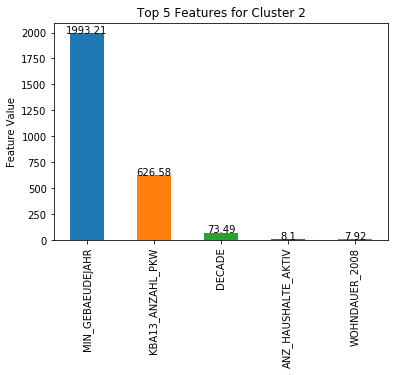

In [283]:
# Plot the top 5 feature values for cluster 2
cluster_chart(2, 5)




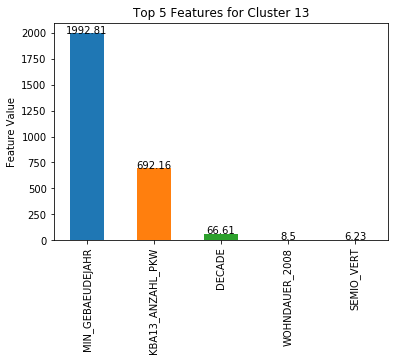

In [284]:
# Plot the top 5 feature values for cluster 13
cluster_chart(13, 5)


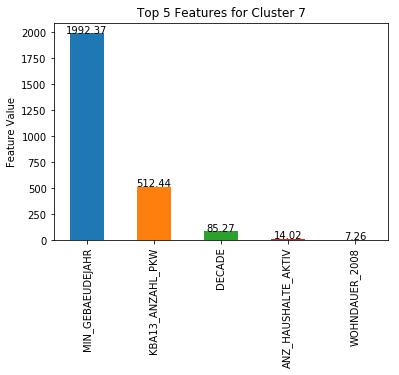

In [285]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Plot the top 5 feature values for cluster 7
cluster_chart(7, 5)


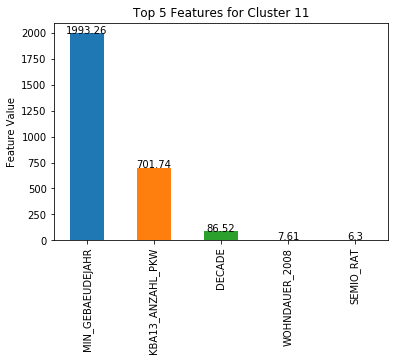

In [286]:
# Plot the top 5 feature values for cluster 11
cluster_chart(11, 5)

### Discussion 3.3: Compare Customer Data to Demographics Data

Clusters 2, 3, 9, 13 are over-represented. Cluster 2 and 13 are the most over-represented. People in these clusters are prime candidate customers.

There are many under-represented clusters, but 17 and 11 are the most under-represented. People in these clusters are not prime candidate customers.

Both of the counts of features in both the over and under-estimated charts looked similar except for cluster 11. DECADE was  higher in both under-represented clusters. we should may want to avoid advertising in areas with lower car density and with older residents.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.